<a href="https://colab.research.google.com/github/swoo-nam/project_final_team1/blob/main/%EB%82%A8%EC%83%81%EC%9A%B0_%EC%9C%A0%EC%98%88%EC%8A%AC_%EC%9E%84%EC%8B%9C%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
!pip install -U sentence-transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
import torch.nn as nn
from torch import optim
from torch import optim

import warnings
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# DATA_PATH = '/content/drive/MyDrive/멀티캠퍼스 자료/Machine Learning/data/'
DATA_PATH = "/content/drive/MyDrive/project_final/data/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# 데이터 불러오기

In [6]:
pd.read_csv(f"{DATA_PATH}train_ft_38000_0918.csv").head(3)

,review,reply,sentiment,score,kiwi_reviews,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494,"['맛있', '먹', '묵사발', '시원', '맛있']",['맛']
1,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408,"['양', '푸짐', '맛있', '청국장', '냄새', '나', '콩', '들', ...","['양', '맛']"
2,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793,"['냉면', '시키', '미니', '냉면', '합치', '양', '적', '보이',...",['양']


In [7]:
pd.read_csv(f"{DATA_PATH}service1_9000_9000.csv").head(3)

,review,reply,sentiment
0,"맛이 별로였어요, 조리 상태도 별로였고 배달 시간도 오래 걸렸네요","안녕하세요~! 맛이 별로였다고 하셨는데, 제 기준에는 싱겁고 딱히 맛있어 보이지 않...",0
1,양도 많고 맛나요,하핫 정말 이런 이런 칭찬에 춤추고 싶네요 든든한 생각나실 때 또 만나요 친절한 고...,1
2,음식의 퀄리티가 낮아서 별로였어요. 맛이 없어서 실망했어요,음식의 퀄리티가 낮아서 실망하셨다니 정말 죄송합니다. 더 맛있는 음식으로 만족스러운...,0


In [8]:
# train = pd.read_csv(f"{DATA_PATH}service1_9000_9000.csv")
train = pd.read_csv(f"{DATA_PATH}train_ft_38000_0918.csv")
train.isnull().sum()

review          0
reply           0
sentiment       0
score           0
kiwi_reviews    0
category        0
dtype: int64

## 하나의 식당 리뷰로 거름

In [9]:
train.shape

(38555, 6)

In [10]:
train['sentiment'].value_counts().sort_index() # 긍부정 분포 확인

0     9115
1    29440
Name: sentiment, dtype: int64

### 단문 데이터 제거
- 데이터 정제 과정에서 무의미해진 데이터는 학습데이터로 사용불가
    - 리뷰 : 공백만 생겼거나, 리뷰 이벤트를 위한 단답형 제거

In [11]:
train[(train['review'].str.len() > 4) & (train['review'].str.len() <= 10)] # 리뷰

,review,reply,sentiment,score,kiwi_reviews,category
7,맛있게잘먹었습니다,고객님! 감사해요! 맛있게 드셨다니 앞으로도 더 열심히 일할게요! 좋은 하루 보내세요~,1,0.565963,"['맛있', '먹']",['맛']
13,맛있게잘먹었어요,고객님께서 맛있다고 말씀 주시니 피로가 싹~ 사라지네요! 주방에서 힘든 일도 있고 ...,1,0.529402,"['맛있', '먹']",['맛']
19,언제나 맛있습니다,소중한 시간에 저희 매장을 다시 이용해주셔서 감사합니다. 이번에도 만족스러우셨던 거...,1,0.641165,['맛있'],['맛']
23,양도 많고 맛있어요,잊지 않으시고 리뷰 남겨주셔서 정말 감사합니다! 맛있는 메뉴들은 매번 양껏 먹어도 ...,1,0.616185,"['양', '많', '맛있']","['양', '맛']"
33,맛있게 잘 먹었어요,고객님도 항상 행복하시길 바라요!,1,0.491652,"['맛있', '먹']",['맛']
...,...,...,...,...,...,...
35619,맛이 별로였어요,죄송합니다. 어떤 부분에서 맛이 별로인지 알려주시면 개선에 도움이 될 것 같습니다.,0,0.918066,['맛'],['맛']
35759,맛이 별로였어요,"죄송해요, 많이 실망하셨군요. 저희 음식이 맛있게 전달되도록 조금 더 노력하겠습니다.",0,0.918066,['맛'],['맛']
36678,맛이 별로였어요,"죄송합니다, 맛에 대해 별점을 받으셨다니 정말 안타깝습니다. 더 맛있는 음식으로 보...",0,0.918066,['맛'],['맛']
36931,맛이 별로였어요.,죄송합니다. 맛이 별로였다니 정말 안타깝네요. 다음에는 더 좋은 맛으로 보답하겠습니다.,0,0.923817,['맛'],['맛']


In [12]:
len(train[train['review'].str.len() <= 10])

3398

In [13]:
train = train[train['review'].str.len() > 10]
train

,review,reply,sentiment,score,kiwi_reviews,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494,"['맛있', '먹', '묵사발', '시원', '맛있']",['맛']
1,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408,"['양', '푸짐', '맛있', '청국장', '냄새', '나', '콩', '들', ...","['양', '맛']"
2,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793,"['냉면', '시키', '미니', '냉면', '합치', '양', '적', '보이',...",['양']
3,맛나게 잘 묵었습니다,"고객님의 즐거운 순간을 함께할 수 있기를 바라며, 기다리고 있겠습니다 더욱 발전된 ...",1,0.549870,"['맛나', '묵']",['맛']
4,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,"안녕하세요! 주문해 주셔서 진심으로 감사드려요! 이렇게 좋은 리뷰 써 주시니, 메뉴...",1,0.778149,"['맛', '양', '만족', '배달', '보내', '만족']","['양', '배달', '맛']"
...,...,...,...,...,...,...
38550,항상 맛있게 먹었는데 이번에는 음식이 식어서 별로였어요. 아쉬워요,고객님의 의견을 반영하여 다양한 맛과 양을 제공하도록 노력하겠습니다.,0,0.811507,"['맛있', '먹', '이번', '음식', '식']",['맛']
38551,언제나 맛있게 먹었는데 이번에는 음식이 지루하고 별로였어요. 아쉬워요,"닭도리탕의 맛이 매우 좋지 않고, 김치가 물렸다는 점 죄송합니다. 앞으로 더 맛있는...",0,0.827452,"['맛있', '먹', '이번', '음식', '지루하']",['맛']
38552,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하셨다니 정말 ...,0,0.942769,"['맛', '음식', '촉촉', '식', '먹', '그렇', '다음', '시키', ...",['맛']
38553,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723,"['맛', '없', '배달', '늦', '실망']","['배달', '맛']"


## 긍부정 데이터 비율 선택

In [14]:
train['sentiment'].value_counts().sort_index() # 긍부정 분포 확인

0     8978
1    26179
Name: sentiment, dtype: int64

In [15]:
train_neg = train[train['sentiment'] == 0]

# 긍정 데이터 중 중복된 답변제거
train_pos = train[train['sentiment'] == 1].drop_duplicates(subset='reply', keep=False)
train_pos['sentiment'].value_counts().sort_index()

1    11510
Name: sentiment, dtype: int64

In [16]:
length = len(train_neg)
length

8978

In [17]:
# 긍정 데이터를 랜덤으로 추출하기 위해 섞기
shuffled_train_pos = train_pos.sample(frac=1, random_state=42)
shuffled_train_neg = train_neg.sample(frac=1, random_state=42)

train_pos = shuffled_train_pos.iloc[:50].reset_index(drop=True)
train_neg = shuffled_train_neg.iloc[:50].reset_index(drop=True)

# 데이터 합치기
train = pd.concat([train_neg, train_pos], ignore_index=True)
train['sentiment'].value_counts().sort_index()

0    50
1    50
Name: sentiment, dtype: int64

In [18]:
# 다시 섞기
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train

,review,reply,sentiment,score,kiwi_reviews,category
0,맛있게 잘 먹었습니당~!,식사전 정성스럽게 셋팅하여 예쁘게 찍어주신 포토리뷰 남겨주셔서 정말 감사합니다~! ...,1,0.477024,"['맛있', '먹']",['맛']
1,매번 시켜먹는데 리뷰는 처음 다네요 주변에 있는 감자탕집중에 제일 맛있어요 변치 않...,"감사합니다,항상 맛있는 음식으로 보답드릴께요 시간내서 리뷰작성해 주셔서 너무너무 감...",1,0.890159,"['시키', '먹', '리뷰', '달', '주변', '있', '감자탕', '집중',...",['맛']
2,고기가 진짜 맛있어요 비위 약해서 돼지고기 원래 잘 못먹는데 이건 무슨 고기가 달아요,맛있게 드셔주셔서 감사드립니다~! 고기는 한우1등급만 쓰고 있고 관리도 정말 철저히...,1,0.837799,"['고기', '맛있', '비위', '약하', '돼지고기', '먹', '고기', '달']",['맛']
3,밥이나 국의 양이 전보다 많이 줄어든거같아요.그리고 오늘 배달을 주문한지 1시간 3...,"정말 죄송합니다. 일단 고기와 밥,국양은 절대 줄이거나 하지 않습니다. 물가가 워낙...",0,0.836672,"['밥', '국', '양', '전', '줄', '같', '배달', '주문', '되'...","['양', '배달']"
4,딱 든든히 별로였어요! 리뷰 서비스로 받은 저 물회는. 기가 막히게 맛없습니다. .,고객님께 더 맛있는 음식을 제공할 수 있도록 노력하겠습니다. 양해 부탁드립니다.,0,0.898117,"['리뷰', '서비스', '물', '회', '기', '막히', '맛없']",['서비스']
...,...,...,...,...,...,...
95,맛있게 잘 먹었습니다,주문과 소중한 좋은 평점 사진리뷰 너무 감사합니다. 언제나 믿고 드실 수 있도록 노...,1,0.538841,"['맛있', '먹']",['맛']
96,비싼감이 있지만 빵이 다양하고 맛있어요 바나나푸딩이랑 시나몬 페스츄리는 맨날 시켜요,"원재료.인건비 상승 압박으로, 가격 만족 드리지 못 해 죄송합니다 소중한 주문 감사...",1,0.506284,"['비싸', '감', '있', '빵', '다양', '맛있', '바나나', '푸딩',...","['가격', '양', '맛']"
97,맛도 별로고 가격도 비싸서 실망했어요.,맛도 별로고 가격도 비싸서 실망하셨다니 정말 죄송합니다. 저희는 항상 맛과 가격의 ...,0,0.928759,"['맛', '가격', '비싸', '실망']","['가격', '맛']"
98,동생이 수술해서 죽을 주문했는데 동생이 너무 너무 맛있게 잘 먹었다고 하네요 정성스...,주문해 주시고 맛있게 드셔주셔서 진심으로 감사합니다 저희 음식이 쾌차에 도움이 되었...,1,0.735881,"['동생', '수술', '죽', '주문', '동생', '맛있', '먹', '하', ...",['맛']


# 1) 유사도 확인

## 유사도 군집화 라벨 불러오기

In [19]:
pd.read_csv(f"{DATA_PATH}sim_cluster_label.csv")

,label
0,맛이 없어요
1,양이 적어요
2,배달이 느려요
3,맛은 있는데 양이 적어요
4,맛은 있는데 배달이 느려요
5,양은 많은데 맛이 없어요
6,배달은 빠른데 맛이 없어요
7,양은 많은데 배달이 느려요
8,배달은 빠른데 양이 적어요
9,맛있어요


In [20]:
sim_cluster_label = pd.read_csv(f"{DATA_PATH}sim_cluster_label.csv")

In [21]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
bert_model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def evaluate_similarity(label_text, review_text, alpha=0.9): # cosine 가중치 조절
    label_embedding = bert_model.encode(label_text)
    review_embedding = bert_model.encode(review_text)

    # 코사인 유사도
    cosine_sim = 1 - pairwise_distances([label_embedding], [review_embedding], metric='cosine')[0][0]

    # 자카드 유사도
    label_tokens = set(label_text.split())
    review_tokens = set(review_text.split())
    jaccard_sim = len(label_tokens.intersection(review_tokens)) / len(label_tokens.union(review_tokens))

    # 가중 평균 내보기
    weighted_sim = alpha*cosine_sim + (1 - alpha)*jaccard_sim

    return weighted_sim

In [22]:
result = []
for label in tqdm(sim_cluster_label['label']):
    for review in train['review']:
        score = evaluate_similarity(label, review)
        if score >= 0.5:
            result.append({'label': label, 'review': review, 'score': score})

result = pd.DataFrame(result)
result

  0%|          | 0/12 [00:00<?, ?it/s]

,label,review,score
0,맛이 없어요,딱 든든히 별로였어요! 리뷰 서비스로 받은 저 물회는. 기가 막히게 맛없습니다. .,0.501663
1,맛이 없어요,음식의 맛이 퇴화되어서 아쉬웠어요. 맛이 살짝 퇴색된 느낌이었어요,0.516526
2,맛이 없어요,서비스가 엉망이에요. 음식도 맛이 없어요,0.581323
3,맛이 없어요,맛있는 것을 기대했지만 실망스러웠어요. 별로였습니다.,0.504134
4,맛이 없어요,양이 너무 적고 맛도 그다지였어요,0.577302
...,...,...,...
131,양이 많아요,양이 상당히 너무 많아요. 일주일째 먹는거 같은데 안줄어드네요 사장님. 마음을 너무...,0.606780
132,양이 많아요,맛도 좋고 양도 푸짐,0.655559
133,배달이 빨라요,역시 마라탕은 라화방이에요 배달도 엄청 빨라서 식지 않고 먹을 수 있고 맛도 있어서...,0.501161
134,배달이 빨라요,맛있어요 배달이 빨라요,0.899375


In [ ]:
# result.to_csv('result.csv', index=False, encoding = "utf-8-sig")

# # 엑셀로 확인
# with pd.ExcelWriter("result.xlsx", engine='openpyxl') as writer:
#     result.to_excel(writer, sheet_name='시트1', index=False)

In [23]:
label_counts = result['label'].value_counts()
label_counts

맛있어요              28
양은 많은데 맛이 없어요     24
맛이 없어요            23
맛은 있는데 양이 적어요     15
배달은 빠른데 맛이 없어요    13
맛은 있는데 배달이 느려요    12
양은 많은데 배달이 느려요     6
양이 많아요             5
양이 적어요             3
배달이 빨라요            3
배달이 느려요            2
배달은 빠른데 양이 적어요     2
Name: label, dtype: int64

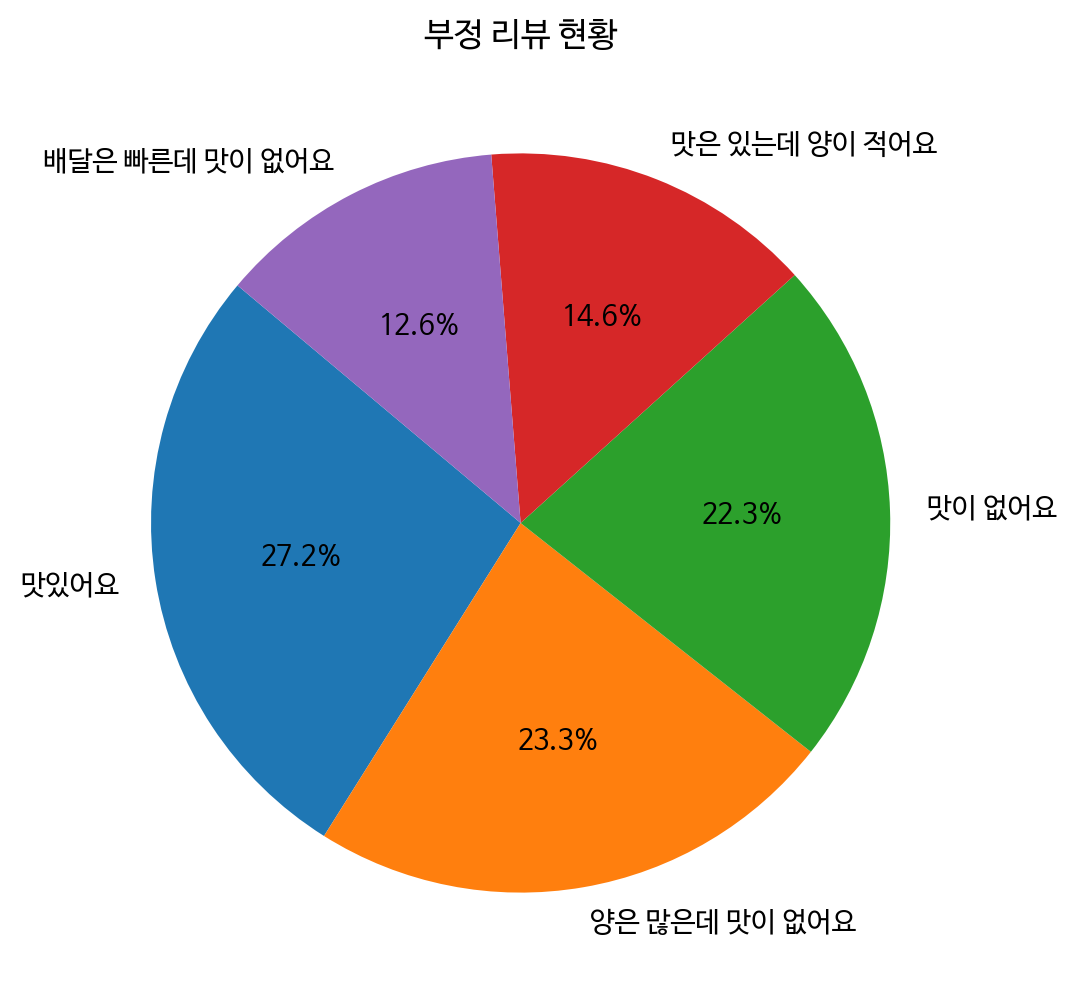

In [24]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='NanumBarunGothic')

plt.figure(figsize=(6, 6))
plt.pie(label_counts[:5], labels=label_counts[:5].index, autopct='%1.1f%%', startangle=140)
plt.title('부정 리뷰 현황')
plt.show()

# 2) 긍부정 지수 변화 추이

In [25]:
shuffled_train_pos

,review,reply,sentiment,score,kiwi_reviews,category
12252,역시나 맛있게 먹었습니다!,반갑습니다~ 최고 별 점 리뷰을 보니 넘 뿌듯합니다~ 저희 1989마라탕 부천점 맛...,1,0.555977,"['맛있', '먹']",['맛']
9270,리뷰이벤트 귀찮아서 요청 안했는데 넘나리 친절하시게도 음료를 넣어주셨더라구여.! 이...,"안녕하세요 맛있게 드셔 주시고, 저희 서비스에 만족해주셔서 부끄럽습니다. 건강을 지...",1,0.898217,"['리뷰', '이벤트', '귀찮', '요청', '하', '친절', '음료', '넣'...",['서비스']
21312,너무 잘 먹었습니다 수박주스 짱맛나요,수박쥬스는 직접 사와 정성스레 손질해서 제조해드려요 ~! 또 한번 찾아주세용 감사드려요,1,0.724990,"['먹', '수박', '주스', '맛나']",['맛']
26445,매번 시켜먹는데 리뷰는 처음 다네요 주변에 있는 감자탕집중에 제일 맛있어요 변치 않...,"감사합니다,항상 맛있는 음식으로 보답드릴께요 시간내서 리뷰작성해 주셔서 너무너무 감...",1,0.890159,"['시키', '먹', '리뷰', '달', '주변', '있', '감자탕', '집중',...",['맛']
27551,배달원분도 너무 친절하시고 음식도 맛있었습니다,잊지 않고 시간 내어 맛있게 드셨다고 남겨주시는 글들을 보며 힘을 얻습니다~! 실망...,1,0.742900,"['배달원', '친절', '음식', '맛있']","['서비스', '맛']"
...,...,...,...,...,...,...
30145,"굿입니다 보장, 배달 다좋았습니다",고객님의 리뷰에 힘이 나고 기분이 좋습니다 오늘 남은 하루도 잘 마무리 하시고 내일...,1,0.745817,"['굿', '보장', '배달', '좋']",['배달']
14222,너무 배불러서 다 못먹었어요 맵기도 적당하구 완전 한국인 입맛을 맞춘 마라탕이었습니...,감사합니다 ~ 맛있게 드셨다는 리뷰는 저희한테 큰 힘이 됩니다 별점 다섯개를 주실수...,1,0.681785,"['배부르', '먹', '적당', '완전', '한국인', '입맛', '맞추', '마...","['양', '맛']"
14797,국물이 진해요 집에서 먹는맛 양도많아서 설명에 써있는대로 둘이서 먹어야 딱 맞네여 ...,안녕하세요 신자매 김치찜 김치찌개를 찾아주셔서 진심으로 감사합니다 구체적인 리뷰 너...,1,0.677440,"['국물', '진하', '집', '먹', '맛', '양', '많', '설명', '쓰...","['양', '맛']"
3602,정말 배부르고 맛있게 잘먹었습니다~,고객님께서 배부르게 드시라고 서비스까지 넉넉히 보내드려요. 브런치 생각나실 때 다시...,1,0.683654,"['배부르', '맛있', '먹']","['양', '맛']"


In [26]:
shuffled_train_neg

,review,reply,sentiment,score,kiwi_reviews,category
36257,서비스가 엉망이에요. 음식도 맛이 없어요,고객님의 소중한 의견을 반영하여 개선해 보도록 하겠습니다.,0,0.909048,"['서비스', '엉망', '음식', '맛', '없']","['서비스', '맛']"
1841,맛나요 오점 드립니다다다다,맛있게 드셔주셔서 감사드립니다 늘 믿고 드실 수 있게 항상 신선한 재료로 정성을 듬...,0,0.829957,"['맛나', '오점', '드리']",['맛']
38024,카레도 별로고 마제소바 너무 별로용 배달도 느리고 감사합니다,고객님의 다음 방문 때는 만족스러운 음식을 제공해드리기 위해 최선을 다하겠습니다. ...,0,0.805398,"['카레', '마제소바', '용', '배달', '느리', '감사']",['배달']
37233,상추가 상했는지 맛이 좀 이상했어요. 다른 샐러드로 주세요.,"안녕하세요, 맛이 좋지 않아 죄송합니다. 음식의 촉촉함을 보장하기 위해 더 노력하겠...",0,0.869637,"['상추', '상하', '맛', '이상', '샐러드', '주']",['맛']
25661,첫주문라 뭐가 무슨 맛인지 몰라 추천 소스로 했는데 제 스타일은 아니였어요 향신료인...,고객님 안녕하세요~ 처음 주문에 만족을 드리지 못한것 같아 정말 안타깝고 죄송합니다...,0,0.681543,"['주문', '라', '맛', '모르', '추천', '소스', '하', '스타일',...",['맛']
...,...,...,...,...,...,...
35306,차갑게 도착해서 실망했습니다. 맛도 그닥이었어요,이해하고 있습니다. 차갑게 도착한 음식과 맛의 부족함으로 인해 실망하셨을 것 같습니...,0,0.927881,"['도착', '실망', '맛']","['배달', '맛']"
34763,맛이 별로였어요. 좀 싱겁고 딱딱해서 먹기가 좀 그랬어요,맛이 별로였다니 싱겁고 딱딱해서 먹기가 그랬다니 안타까워요. 저희는 맛있는 음식을 ...,0,0.933474,"['맛', '딱딱하', '먹', '그렇']",['맛']
34962,음식이 식어서 왔어요. 회가 싱싱하지 않아서 맛이 좋지 않았어요. 당연히 늦게 배달...,음식이 식어서 오셨다니 정말 죄송합니다. 저희가 배송 시간과 신선도에 더 신경을 쓸...,0,0.943574,"['음식', '식', '오', '회', '싱싱', '맛', '좋', '늦', '배달...","['배달', '맛']"
21406,생각보다 매운맛은 아니에요! 맵찔이도 먹을 수 있습니당,저희 타코야키 매운맛은 매콤하고 맛있는 매움이라 누구나 맛있게 즐기실 수 있습니다!...,0,0.414531,"['생각', '맛', '먹', '있']",['맛']


In [ ]:
# train = pd.concat([shuffled_train_pos, shuffled_train_neg], ignore_index=True)
# train.shape

(20488, 6)

In [ ]:
# mask = (train['review'].str.contains('고기|돼지|국물')) | (train['reply'].str.contains('고기|돼지|국물'))
# train = train[mask]
# train.shape

(1328, 6)

# 여기서부터

In [79]:
train_pos = shuffled_train_pos.iloc[:500].reset_index(drop=True)
train_neg = shuffled_train_neg.iloc[:500].reset_index(drop=True)

# 데이터 합치기
train_posneg_1000 = pd.concat([train_neg, train_pos], ignore_index=True)


In [80]:
train_posneg_1000 = train_posneg_1000.sample(frac=1)
train_posneg_1000['ID'] = 0
train_posneg_1000['date'] = 0

In [81]:
train_posneg_1000.reset_index(drop=True, inplace=True)
train_posneg_1000

,review,reply,sentiment,score,kiwi_reviews,category,ID,date
0,3인시켰는데 생각보다양이많았어요 우동은 양념이랑 따로 주시는게 더 좋을것같아요 같이...,수제햄 부대찌개는수제햄이 많이들어가서 드시다보면 양이 적지는 않은 메뉴랍니다 우동을...,1,0.406734,"['인', '생각', '양', '많', '우동', '양념', '주', '좋', '같...",['양'],0,0
1,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",이용해 주셔서 대단히 죄송합니다. 맛과 촉감에 대한 신경을 더욱 써서 향상시킬 것입...,0,0.942769,"['맛', '음식', '촉촉', '식', '먹', '그렇', '다음', '시키', ...",['맛'],0,0
2,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님이 언급하신 문제에 대해서 저희에겐 큰 문제로 인식하고 더욱 개선하도록 하겠습...,0,0.942769,"['맛', '음식', '촉촉', '식', '먹', '그렇', '다음', '시키', ...",['맛'],0,0
3,여기 족발 먹고나면 다른집은 못먹겠어요 족발이 먹고싶은데 여기 쉬는 날이면 족발을 ...,우와~ 이렇게 감동을 주는 리뷰 남겨줄 수 있나요? 직화족발이 처음에 영접할때는 왜...,1,0.883324,"['족발', '먹', '집', '먹', '족발', '먹', '쉬', '날', '족발...","['양', '맛']",0,0
4,"정확한 배달시간, 적당한 양, 신선한 재료, 합리적인 가격. 가서만 먹다가 배달해봤...","고객님, 배달로 이렇게 또 찾아주셔서 감사합니다 앞으로도 좋은 음식으로 찾아뵐수 있...",1,0.765442,"['정확', '배달', '시간', '적당', '양', '신선', '재료', '합리'...","['가격', '양', '배달', '맛']",0,0
...,...,...,...,...,...,...,...,...
995,배달이 너무 늦어서 음식이 다 식어서 왔어요. 정말 실망이에요.,고객님들의 만족을 위해 최선을 다하고 있습니다. 앞으로 더 좋은 경험을 제공할 수 ...,0,0.925735,"['배달', '늦', '음식', '식', '오', '실망']",['배달'],0,0
996,"짬뽕에는 다양한 재료가 있어야 하는데, 여기는 재료가 너무 적어서 실망했어요.",재료가 부족하셨나요? 앞으로 더 다양한 재료로 짬뽕을 만들어드리도록 하겠습니다. 제...,0,0.907437,"['짬뽕', '다양', '재료', '있', '재료', '적', '실망']",['양'],0,0
997,딱 든든히 별로였어요! 리뷰 서비스로 받은 저 물회는. 기가 막히게 맛없습니다. .,고객님께 더 맛있는 음식을 제공할 수 있도록 노력하겠습니다. 양해 부탁드립니다.,0,0.898117,"['리뷰', '서비스', '물', '회', '기', '막히', '맛없']",['서비스'],0,0
998,처음시켰는데 샐러드도 같이 나오고 양이 많네요~ 맛았게 잘먹었습니다,"첫 주문 반갑고 감사합니다 네네, 초밥과 샐러드, 국물 구성으로 한 끼 드시기에 좋...",1,0.463130,"['처음', '샐러드', '나오', '양', '많', '맛았게', '먹']",['양'],0,0


- 서로 다른 6자의 아이디 랜덤 생성 / 1월 1일~ 9월 30일까지의 데이터 / 고객 구매주기는 하루 ~ 3달까지 다양함

In [82]:
import random
import string
from datetime import datetime, timedelta
import pandas as pd

# 데이터를 저장할 리스트 초기화
data = []

# 시작 날짜와 종료 날짜 설정
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 9, 30)

# 중복 아이디 생성을 위한 아이디 리스트
all_ids = []

# 1000개의 데이터 생성
while len(data) < 1000:
    # 랜덤 문자열 아이디 생성 (예: 6자리 길이)
    customer_id = ''.join(random.choices(string.ascii_letters + string.digits, k=6))

    # 무작위 시작 날짜 생성 (start_date와 end_date 사이)
    start_date_random = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))

    # 1일부터 2달에서 3달 사이의 반복 주기 생성
    repeat_period = random.randint(1, 180)

    current_date = start_date_random
    while current_date <= end_date and len(data) < 1000:
        data.append({'ID': customer_id, 'date': current_date})
        current_date += timedelta(days=repeat_period)

# 데이터프레임 생성
df = pd.DataFrame(data)

# 날짜순으로 데이터프레임 정렬
df.sort_values(by=['date'], inplace=True)

# 데이터프레임 출력
df


,ID,date
800,Bj63jP,2023-07-01
370,197IZc,2023-07-01
159,iZiC1I,2023-07-01
546,ixHbIp,2023-07-01
311,ZOttwY,2023-07-01
...,...,...
741,Su694u,2023-09-30
744,OGesko,2023-09-30
747,Rpx7NP,2023-09-30
866,eriKGI,2023-09-30


In [83]:
df = pd.concat([df,train_posneg_1000[['review','reply','sentiment','score']]], axis=1)
df

,ID,date,review,reply,sentiment,score
800,Bj63jP,2023-07-01,맛이 좋지 않았어요. 피자도 맛이 없었고 토핑도 많이 부족해요.,고객님의 의견을 적극 반영하여 더욱 개선된 피자를 제공하도록 하겠습니다.,0,0.916540
370,197IZc,2023-07-01,회차 너무너무너무 맛없음 채소가 정말 상한하고 맛없고 다양함,고객님의 의견을 최대한 수용하여 제품 개선을 위해 노력하겠습니다.,0,0.901827
159,iZiC1I,2023-07-01,진짜 최악이었어요. 맛도 없고 음식이 다 뜨거운 상태에서 도착해서 다 식어버렸어요,맛없고 음식이 식은 상태로 도착해서 정말 죄송합니다. 앞으로는 음식의 상태를 더 신...,0,0.922164
546,ixHbIp,2023-07-01,"지난 번 배달 때 메뉴 착오가 있었어서 리뷰 남겼었는데, 오늘은 착오 없이 배달도 ...",고객님께 만족감 그 자체를 드리고 싶었는데! 미션성공 다음에도 기회가 된다면 저희와...,1,0.512987
311,ZOttwY,2023-07-01,양이 너무 적었어요. 서비스도 별로였어요.,고객님께 불편을 드린 것 같아 안타깝습니다.,0,0.929859
...,...,...,...,...,...,...
741,Su694u,2023-09-30,간짜장도 너무 짜서 맛이 별로였어요. 면도 부드럽지 않았어요.,간짜장이 너무 짜서 맛이 좋지 않았다는 점 이해합니다. 면의 부드러움도 부족했다고 ...,0,0.911537
744,OGesko,2023-09-30,배달비가 무료라 시킨곳이었는데 넘 맛있었어요~ 페퍼로니 피자 짱맛! 바게트도 짱맛,고객님들에게. 최고의 선물은 모어댄버터가 아닐까 싶습니다. 석촌역과 잠실역 사이에 ...,1,0.635324
747,Rpx7NP,2023-09-30,콘치즈가 진짜 맛이 없어요. 바삭하지도 않고 싱겁고 텁텁한데 맛이없어서 실망이에요,콘치즈의 맛이 싱겁고 바삭하지 않았다니 정말 죄송합니다. 맛에 대한 피드백을 적극적...,0,0.909953
866,eriKGI,2023-09-30,음식이 양념이 너무 진해서 입맛에 맞지 않았어요. 다른 음식을 시킬 걸 그랬어요,고객님의 입맛에 맞는 음식을 제공하기 위해 최선을 다하겠습니다. 다음 주문시에는 만...,0,0.908353


In [84]:
df_neg = df[df['sentiment'] == 0]
df_pos = df[df['sentiment'] == 1]

df_neg.shape, df_pos.shape

((500, 6), (500, 6))

- 7일 단위

In [85]:
# 인덱스 설정해서 7D 단위로 확인
df_pos.set_index('date', inplace=True)
df_neg.set_index('date', inplace=True)

df_pos['score'].resample('7D').sum()

date
2023-07-01     8.810618
2023-07-08    11.037278
2023-07-15    14.276415
2023-07-22    24.537378
2023-07-29    19.824204
2023-08-05    19.864534
2023-08-12    19.157378
2023-08-19    22.084234
2023-08-26    34.100218
2023-09-02    37.889038
2023-09-09    34.628467
2023-09-16    33.878381
2023-09-23    38.783428
2023-09-30     4.028438
Freq: 7D, Name: score, dtype: float64

In [86]:
df_pos['score'].resample('7D').sum().reset_index()

,date,score
0,2023-07-01,8.810618
1,2023-07-08,11.037278
2,2023-07-15,14.276415
3,2023-07-22,24.537378
4,2023-07-29,19.824204
5,2023-08-05,19.864534
6,2023-08-12,19.157378
7,2023-08-19,22.084234
8,2023-08-26,34.100218
9,2023-09-02,37.889038


In [87]:
# 7일 간격으로 데이터 합산한 거 반영하기
pos_7D_score = df_pos['score'].resample('7D').sum().reset_index()
neg_7D_score = df_neg['score'].resample('7D').sum().reset_index()

In [88]:
merged_df = pd.merge(pos_7D_score, neg_7D_score, on='date').rename(columns={'date':'date', 'score_x':'pos_7D_score', 'score_y':'neg_7D_score'})
merged_df

,date,pos_7D_score,neg_7D_score
0,2023-07-01,8.810618,17.325665
1,2023-07-08,11.037278,21.089351
2,2023-07-15,14.276415,20.726445
3,2023-07-22,24.537378,16.401579
4,2023-07-29,19.824204,22.869996
5,2023-08-05,19.864534,30.917248
6,2023-08-12,19.157378,32.508414
7,2023-08-19,22.084234,36.110941
8,2023-08-26,34.100218,40.938650
9,2023-09-02,37.889038,42.957800


- 일자별

In [ ]:
# pos_daily_sentiment = df_pos.groupby('date')['score'].sum().reset_index()
# pos_daily_sentiment.columns = ['date','pos_daily_score']


In [ ]:
# neg_daily_sentiment = df_neg.groupby('date')['score'].sum().reset_index()
# neg_daily_sentiment.columns = ['date','neg_daily_score']

In [ ]:
# merged_df = pd.merge(pos_daily_sentiment, neg_daily_sentiment, on='date')
# merged_df

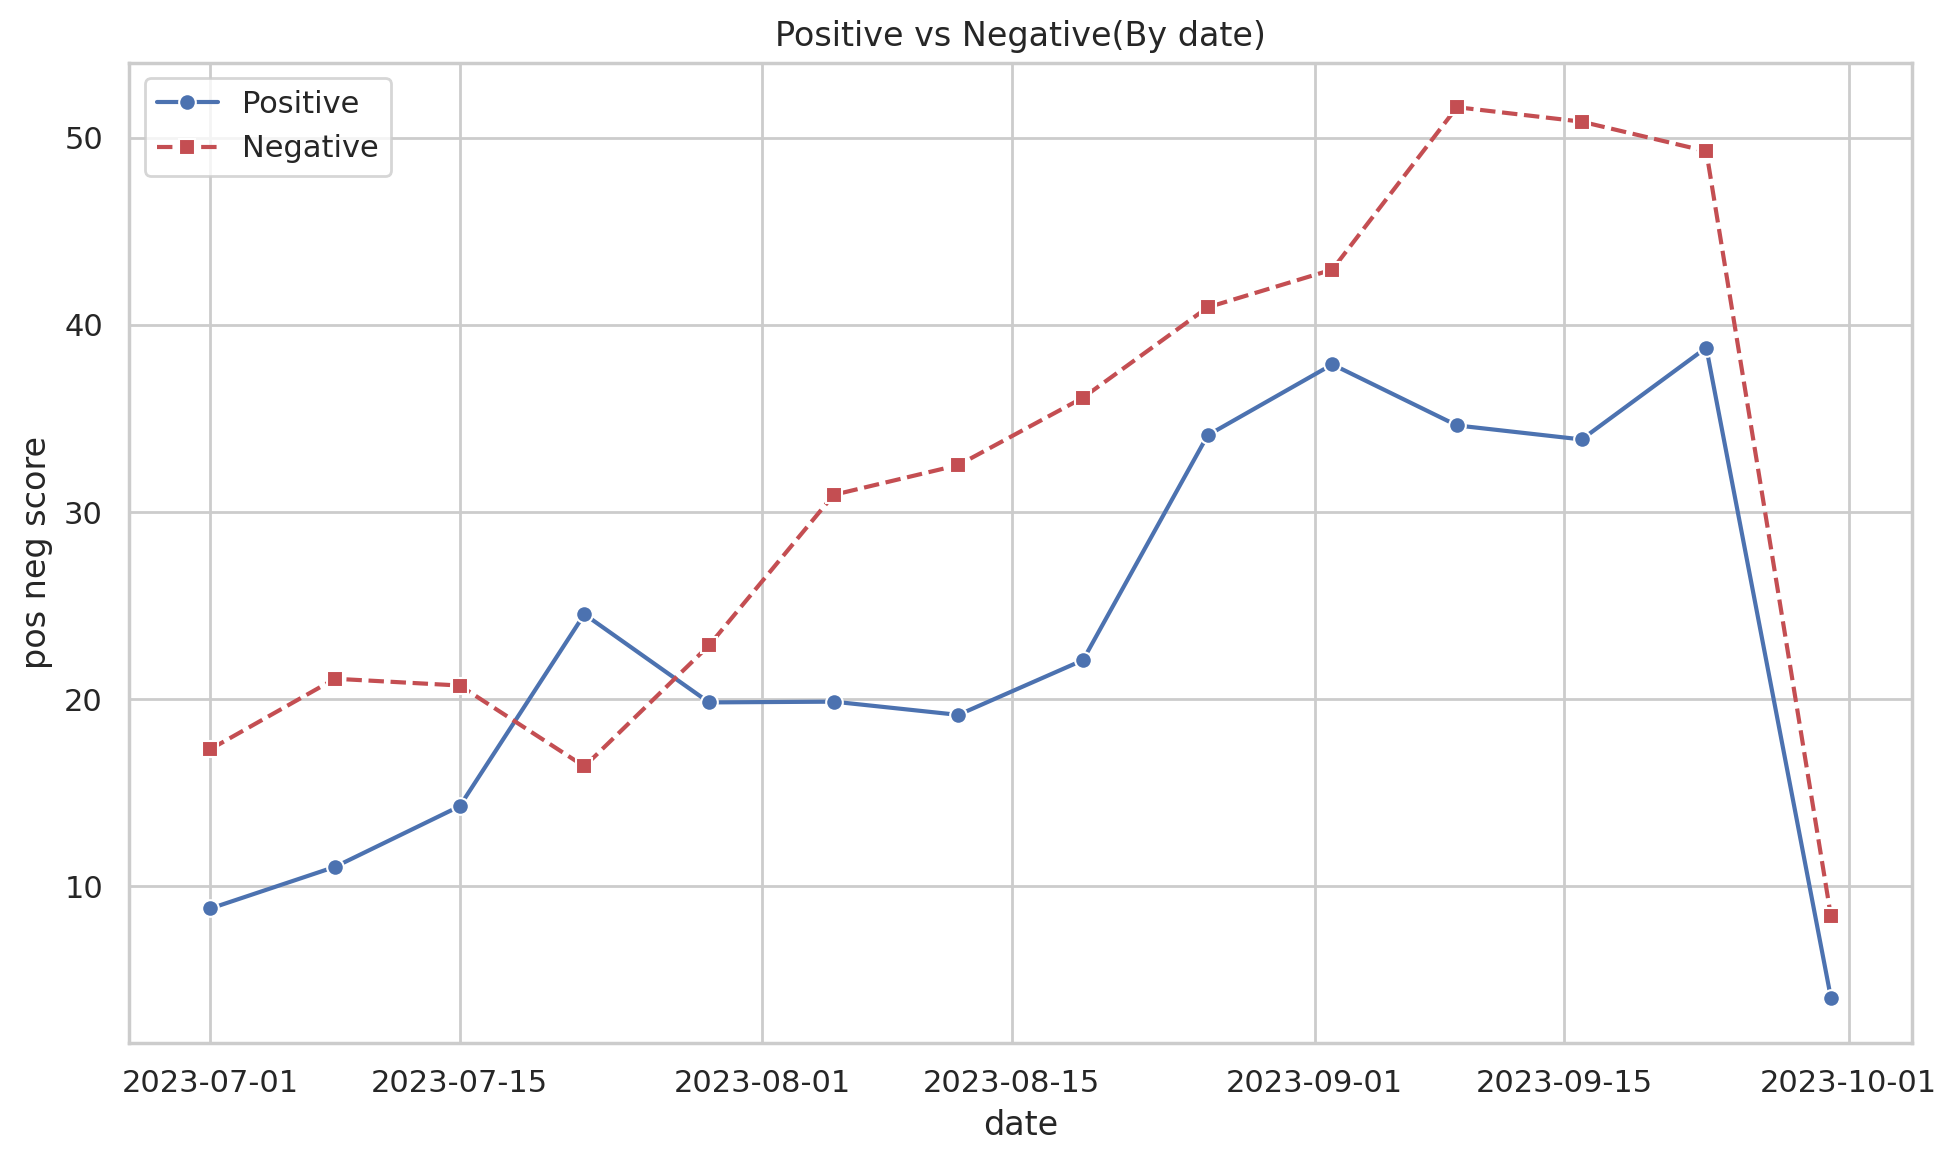

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 날짜를 Datetime 형식으로 변환
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

# score 1 그래프 그리기
sns.lineplot(data=merged_df, x='date', y='pos_7D_score', label='Positive', marker='o', linestyle='-', color='b')

# score 2 그래프 그리기
sns.lineplot(data=merged_df, x='date', y='neg_7D_score', label='Negative', marker='s', linestyle='--', color='r')

# 그래프 제목과 레이블 설정
plt.title('Positive vs Negative(By date)')
plt.xlabel('date')
plt.ylabel('pos neg score')

# 범례 추가
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


# 3) (보류) 부정지수 토픽별 분포도

In [ ]:
#대충 이 부분을 어떻게 설명하면 좋을 지

,ID,날짜
0,SJho1Q,2023-08-02
1,OcPtMQ,2023-08-13
2,OcPtMQ,2023-08-21
3,OcPtMQ,2023-08-29
4,OcPtMQ,2023-09-06
...,...,...
995,k1orjz,2023-07-14
996,k1orjz,2023-07-31
997,k1orjz,2023-08-17
998,k1orjz,2023-09-03


# 4) 고객별 온도 확인 (리뷰 빈도 / 긍부정 / 토픽)

In [90]:
df

,ID,date,review,reply,sentiment,score
800,Bj63jP,2023-07-01,맛이 좋지 않았어요. 피자도 맛이 없었고 토핑도 많이 부족해요.,고객님의 의견을 적극 반영하여 더욱 개선된 피자를 제공하도록 하겠습니다.,0,0.916540
370,197IZc,2023-07-01,회차 너무너무너무 맛없음 채소가 정말 상한하고 맛없고 다양함,고객님의 의견을 최대한 수용하여 제품 개선을 위해 노력하겠습니다.,0,0.901827
159,iZiC1I,2023-07-01,진짜 최악이었어요. 맛도 없고 음식이 다 뜨거운 상태에서 도착해서 다 식어버렸어요,맛없고 음식이 식은 상태로 도착해서 정말 죄송합니다. 앞으로는 음식의 상태를 더 신...,0,0.922164
546,ixHbIp,2023-07-01,"지난 번 배달 때 메뉴 착오가 있었어서 리뷰 남겼었는데, 오늘은 착오 없이 배달도 ...",고객님께 만족감 그 자체를 드리고 싶었는데! 미션성공 다음에도 기회가 된다면 저희와...,1,0.512987
311,ZOttwY,2023-07-01,양이 너무 적었어요. 서비스도 별로였어요.,고객님께 불편을 드린 것 같아 안타깝습니다.,0,0.929859
...,...,...,...,...,...,...
741,Su694u,2023-09-30,간짜장도 너무 짜서 맛이 별로였어요. 면도 부드럽지 않았어요.,간짜장이 너무 짜서 맛이 좋지 않았다는 점 이해합니다. 면의 부드러움도 부족했다고 ...,0,0.911537
744,OGesko,2023-09-30,배달비가 무료라 시킨곳이었는데 넘 맛있었어요~ 페퍼로니 피자 짱맛! 바게트도 짱맛,고객님들에게. 최고의 선물은 모어댄버터가 아닐까 싶습니다. 석촌역과 잠실역 사이에 ...,1,0.635324
747,Rpx7NP,2023-09-30,콘치즈가 진짜 맛이 없어요. 바삭하지도 않고 싱겁고 텁텁한데 맛이없어서 실망이에요,콘치즈의 맛이 싱겁고 바삭하지 않았다니 정말 죄송합니다. 맛에 대한 피드백을 적극적...,0,0.909953
866,eriKGI,2023-09-30,음식이 양념이 너무 진해서 입맛에 맞지 않았어요. 다른 음식을 시킬 걸 그랬어요,고객님의 입맛에 맞는 음식을 제공하기 위해 최선을 다하겠습니다. 다음 주문시에는 만...,0,0.908353


In [ ]:
# from transformers import pipeline

# model = pipeline(model="WhitePeak/bert-base-cased-Korean-sentiment")

# result_df = pd.DataFrame(columns=['review', 'label', 'score'])
# for review in tqdm(df['review']):
#     posneg = model(review)
#     label = posneg[0]['label']
#     score = posneg[0]['score']

#     result_df = result_df.append({'review': review, 'label': label, 'score': score}, ignore_index=True)

# temp_df = pd.concat([df.iloc[:,:2].reset_index(drop=True), result_df],axis=1)

# def change_score(df):
#     if df['label'] == 'LABEL_0':
#         return -df['score']
#     else:
#         return df['score']

# temp_df['score'] = temp_df.apply(change_score, axis=1)

# rename = {'LABEL_0': '부정', 'LABEL_1': '긍정'}
# temp_df['label'] = temp_df['label'].replace(rename)
# temp_df

In [98]:
temp_df = df.reset_index(drop=True)

def change_score(df):
    if df['sentiment'] == 0:
        return -df['score']
    else:
        return df['score']

temp_df['score'] = temp_df.apply(change_score, axis=1)
temp_df

,ID,date,review,reply,sentiment,score
0,Bj63jP,2023-07-01,맛이 좋지 않았어요. 피자도 맛이 없었고 토핑도 많이 부족해요.,고객님의 의견을 적극 반영하여 더욱 개선된 피자를 제공하도록 하겠습니다.,0,-0.916540
1,197IZc,2023-07-01,회차 너무너무너무 맛없음 채소가 정말 상한하고 맛없고 다양함,고객님의 의견을 최대한 수용하여 제품 개선을 위해 노력하겠습니다.,0,-0.901827
2,iZiC1I,2023-07-01,진짜 최악이었어요. 맛도 없고 음식이 다 뜨거운 상태에서 도착해서 다 식어버렸어요,맛없고 음식이 식은 상태로 도착해서 정말 죄송합니다. 앞으로는 음식의 상태를 더 신...,0,-0.922164
3,ixHbIp,2023-07-01,"지난 번 배달 때 메뉴 착오가 있었어서 리뷰 남겼었는데, 오늘은 착오 없이 배달도 ...",고객님께 만족감 그 자체를 드리고 싶었는데! 미션성공 다음에도 기회가 된다면 저희와...,1,0.512987
4,ZOttwY,2023-07-01,양이 너무 적었어요. 서비스도 별로였어요.,고객님께 불편을 드린 것 같아 안타깝습니다.,0,-0.929859
...,...,...,...,...,...,...
995,Su694u,2023-09-30,간짜장도 너무 짜서 맛이 별로였어요. 면도 부드럽지 않았어요.,간짜장이 너무 짜서 맛이 좋지 않았다는 점 이해합니다. 면의 부드러움도 부족했다고 ...,0,-0.911537
996,OGesko,2023-09-30,배달비가 무료라 시킨곳이었는데 넘 맛있었어요~ 페퍼로니 피자 짱맛! 바게트도 짱맛,고객님들에게. 최고의 선물은 모어댄버터가 아닐까 싶습니다. 석촌역과 잠실역 사이에 ...,1,0.635324
997,Rpx7NP,2023-09-30,콘치즈가 진짜 맛이 없어요. 바삭하지도 않고 싱겁고 텁텁한데 맛이없어서 실망이에요,콘치즈의 맛이 싱겁고 바삭하지 않았다니 정말 죄송합니다. 맛에 대한 피드백을 적극적...,0,-0.909953
998,eriKGI,2023-09-30,음식이 양념이 너무 진해서 입맛에 맞지 않았어요. 다른 음식을 시킬 걸 그랬어요,고객님의 입맛에 맞는 음식을 제공하기 위해 최선을 다하겠습니다. 다음 주문시에는 만...,0,-0.908353


고객 ID: 3rXXjl


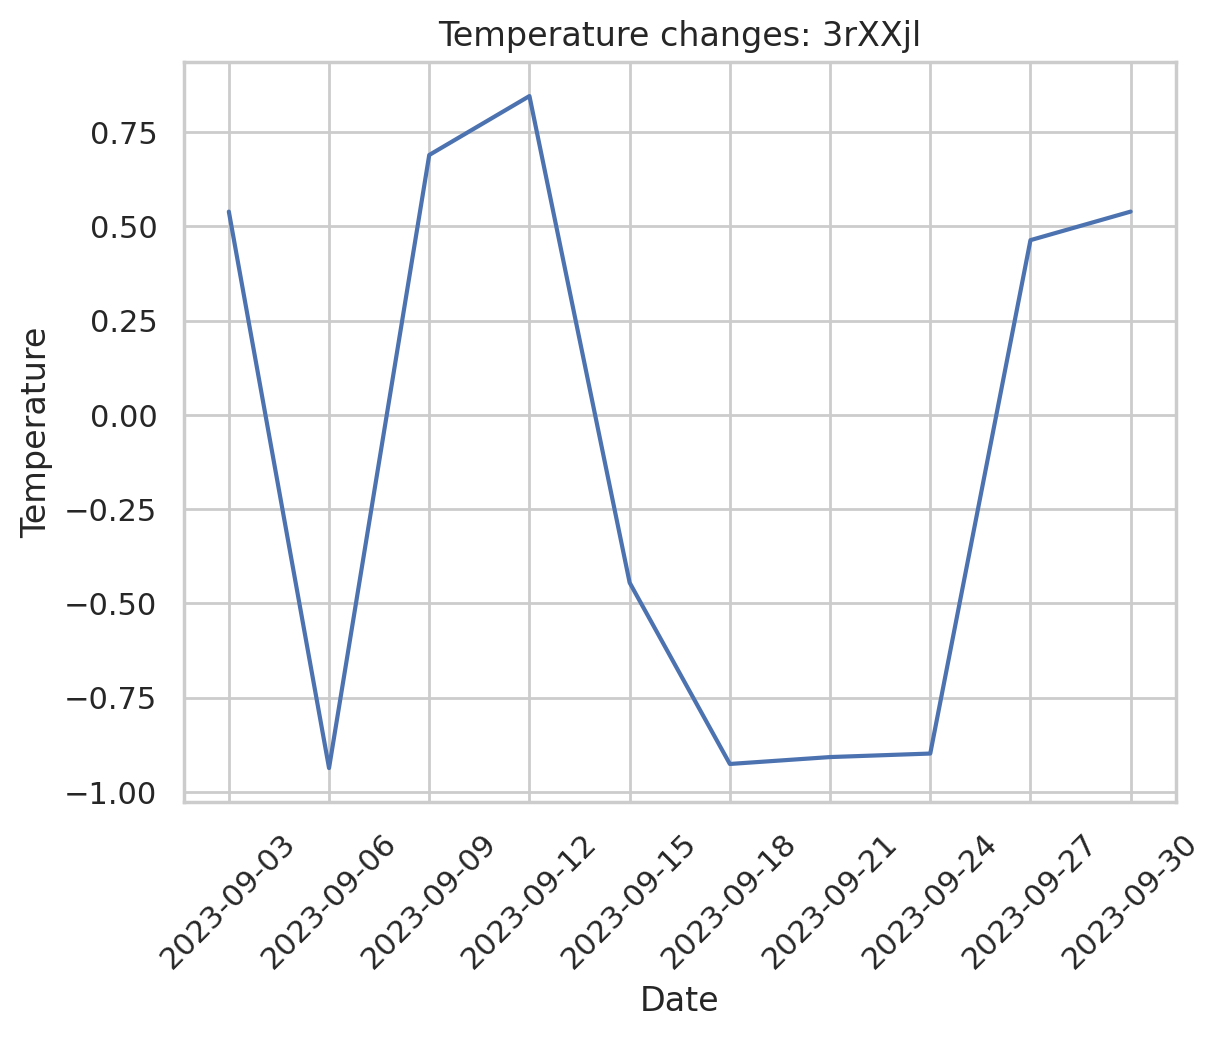

In [99]:
input_id = input("고객 ID: ")

id_df = temp_df[temp_df['ID'] == input_id]

if not id_df.empty:
    plt.plot(id_df['date'], id_df['score'])
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title(f'Temperature changes: {input_id}')
    plt.xticks(id_df['date'], rotation=45)
    plt.show()
else:
    print(f"{input_id} : 없는 ID 입니다.")